# Notebook to integrate data with graph

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
import math
from numpy import linalg as LA
import numpy as np
import random

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Generate network of Rotterdam using a bounding box

In [2]:
graph = ox.graph_from_bbox(51.970486, 51.863171, 4.580918, 4.427773,  network_type="drive")
# (51.863171, 4.427773, 51.970486, 4.580918) -> lat\_s, lon\_w, lat\_n, lon\_e)


C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


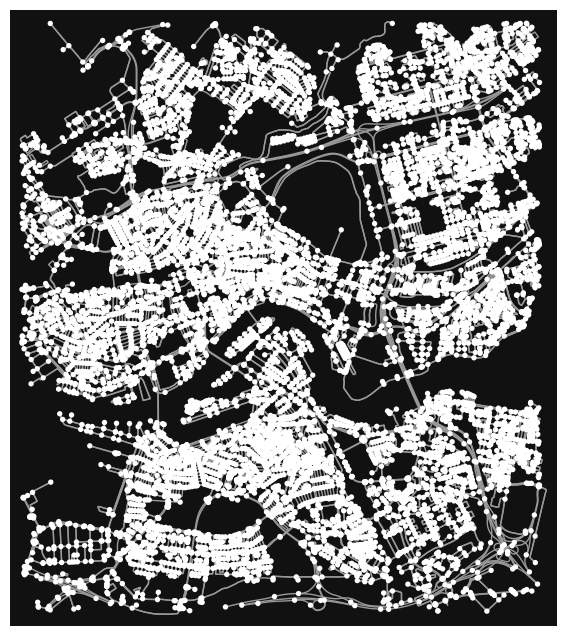

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(graph)

In [4]:
ox.io.save_graphml(graph, filepath="rotterdam_drive_basic.graphml")

## Integrate the different data types into the graph

### Integrate camera data into graph

In [3]:
df_fixed= pd.read_excel('../../data/cameras/camer_data_fixed.xlsx')   

In [5]:
filepath="../../graph/rotterdam_drive_basic.graphml"
graph=ox.load_graphml(filepath)

In [25]:
len(df_fixed)

76

Remove the camera data points that are outside the bounding box

In [26]:
#delete the cameras that are outside the bounding box
for index, row in df_fixed.iterrows():
    if row['Latitude'] < 51.863171 or row['Latitude'] > 51.970486 :
        df_fixed = df_fixed.drop(index)
    elif row['Longitude'] < 4.427773  or row['Longitude'] > 4.580918:
        df_fixed = df_fixed.drop(index)
        

In [27]:
len(df_fixed)

34

Calculate the nodes closest to the lat/lon positions of the cameras and add camera data point to these nodes

In [50]:
for index, row in df_fixed.iterrows():
    
    closest_node_1 = None
    closest_node_2 = None
    closest_distance = math.inf 
    
    for node, data_node in graph.nodes(data=True):
        for node_num in graph.neighbors(node):
            if graph[node][node_num].get(0)["highway"] not in ['motorway', 'trunk']:
                continue
            p1 = np.asarray((data_node['y'], data_node['x']))
            p2 = np.asarray((graph.nodes[node_num]['y'], graph.nodes[node_num]['x']))
            p3 = np.asarray((row['Latitude'], row['Longitude']))
        
            distance = LA.norm(np.cross(p2-p1, p1-p3))/LA.norm(p2-p1)
            
            if distance < closest_distance:
                closest_distance = distance
                closest_node_1 = node
                closest_node_2 = node_num
                
    nx.set_node_attributes(graph, {closest_node_1: {'camera': True}})
    nx.set_node_attributes(graph, {closest_node_2: {'camera': True}})
                
    nx.set_edge_attributes(graph, {(closest_node_1, closest_node_2, 0): {'camera': True}})
    nx.set_edge_attributes(graph, {(closest_node_1, closest_node_2, 1): {'camera': True}})
    nx.set_edge_attributes(graph, {(closest_node_2, closest_node_1, 0): {'camera': True}})
    nx.set_edge_attributes(graph, {(closest_node_2, closest_node_1, 1): {'camera': True}})
    

Check the number of nodes that have a ANPR camera

In [51]:
nodes_with_camera = 0
for u, data in graph.nodes(data=True):
    if 'camera' in data:
        nodes_with_camera =  nodes_with_camera + 1

In [52]:
nodes_with_camera

164

Check the number of edges and their total length that have a ANPR camera

In [10]:
edges_with_camera = 0
length_camera = 0
for (u, v, data) in graph.edges(data=True):
    if 'camera' in data:
        edges_with_camera =  edges_with_camera + 1
        length_camera +=  data['length']

In [9]:
edges_with_camera

101

In [11]:
length_camera

18338.888999999996

In [55]:
ox.io.save_graphml(graph, filepath="../graph/rotterdam_drive_bbox_cameras.graphml")

### Add traffic lights to graph

In [7]:
filepath="../../graph/rotterdam_drive_bbox_cameras.graphml"
graph=ox.load_graphml(filepath)

In [57]:
traffic_light_path = "../data/traffic_lights/export.json"
traffic_lights = pd.read_json(traffic_light_path, orient='records')

In [58]:
traffic_lights

,type,id,lat,lon,tags
0,node,44142421,51.865208,4.552909,{'highway': 'traffic_signals'}
1,node,44149687,51.867113,4.441096,{'highway': 'traffic_signals'}
2,node,44151923,51.867670,4.445920,{'highway': 'traffic_signals'}
3,node,44158228,51.869297,4.453159,"{'highway': 'traffic_signals', 'traffic_signal..."
4,node,44159183,51.869497,4.453119,{'highway': 'traffic_signals'}
...,...,...,...,...,...
2187,node,10573288194,51.923111,4.478535,{'highway': 'traffic_signals'}
2188,node,10573288195,51.923285,4.478502,{'highway': 'traffic_signals'}
2189,node,10573288196,51.923185,4.478835,"{'highway': 'traffic_signals', 'traffic_signal..."
2190,node,10839235314,51.884382,4.490026,"{'highway': 'traffic_signals', 'traffic_signal..."


Check if node ids of traffic lights match the ids of the nodes in the graph.
They don't so they need ot be matched on lat/lon

In [10]:
counter = 0
for index, row in traffic_lights.iterrows():
    if graph.has_node(row['id']):
        counter +=1

In [11]:
counter

3

In [12]:
traffic_lights.iloc[0]

type                              node
id                            44142421
lat                          51.865208
lon                           4.552909
tags    {'highway': 'traffic_signals'}
Name: 0, dtype: object

In [20]:
x_edge = random.choice(list(graph.nodes(data=True)))

In [21]:
x_edge

(44270503, {'y': 51.8919143, 'x': 4.4688409, 'street_count': 1})

Calculate the nodes closest to the lat/lon positions of the traffic light and add a traffic light data point to these nodes

In [69]:
for index, row in traffic_lights.iterrows():
    
    closest_node = None
    closest_distance = math.inf 
    
    for index1, node in graph.nodes(data=True):
        distance = math.dist([row['lat'], row['lon']], [node.get("y"), node.get("x")])
        if distance < closest_distance:
            closest_distance = distance
            closest_node = index1
            
    nx.set_node_attributes(graph, {closest_node: {'traffic_light': True}})
    
    for u, v in graph.in_edges(nbunch=closest_node):
        nx.set_edge_attributes(graph, {(u, v, 0): {'traffic_light': True}})
        nx.set_edge_attributes(graph, {(u, v, 1): {'traffic_light': True}})

Count number of node with a traffic light

In [70]:
nodes_with_traffic_lights = 0
for v, data in graph.nodes(data=True):
    if 'traffic_light' in data:
        nodes_with_traffic_lights =  nodes_with_traffic_lights + 1

In [71]:
nodes_with_traffic_lights

912

Count number of edges and their total length with traffic lights

In [14]:
edges_with_traffic_lights = 0
length_traffic_lights = 0
for (u, v, data) in graph.edges(data=True):
    if 'traffic_light' in data:
        edges_with_traffic_lights =  edges_with_traffic_lights + 1
        length_traffic_lights += data['length']

In [15]:
edges_with_traffic_lights

1781

In [16]:
length_traffic_lights

176023.9480000005

In [74]:
ox.io.save_graphml(graph, filepath="../graph/rotterdam_drive_bbox_cameras_and_traffic_lights.graphml")

### Add bridges

In [13]:
filepath="../../graph/rotterdam_drive_bbox_cameras_and_traffic_lights.graphml"
graph=ox.load_graphml(filepath)

In [76]:
bridges_path = "../data/bridges/export.json"
bridges = pd.read_json(bridges_path, orient='records')

In [77]:
bridges_on_nodes = bridges[bridges['type']=='node']

In [78]:
bridges_on_nodes

,type,id,nodes,tags,lat,lon
23,node,5313597287,NaN,NaN,51.906264,4.448596
24,node,5313597288,NaN,NaN,51.906276,4.448055
25,node,5313597289,NaN,NaN,51.906242,4.448055
26,node,5313597290,NaN,NaN,51.906232,4.448592
27,node,8437277790,NaN,NaN,51.916638,4.443798
...,...,...,...,...,...,...
146,node,2405631460,NaN,NaN,51.921322,4.498191
147,node,2405631461,NaN,NaN,51.921037,4.498107
148,node,2405631469,NaN,NaN,51.921119,4.498362
149,node,745637382,NaN,NaN,51.955601,4.518518


Calculate the nodes closest to the lat/lon positions of the bridge and add a bridge data point to these nodes

In [79]:
for index, row in bridges_on_nodes.iterrows():
    
    closest_node = None
    closest_distance = math.inf 
    
    for index1, node in graph.nodes(data=True):
        distance = math.dist([row['lat'], row['lon']], [node.get("x"), node.get("y")])
        if distance < closest_distance:
            closest_distance = distance
            closest_node = index1
            
    
    nx.set_node_attributes(graph, {closest_node: {'traffic_light': True}})
    
    for u, v in graph.in_edges(nbunch=closest_node):
        nx.set_edge_attributes(graph, {(u, v, 0): {'traffic_light': True}})
        nx.set_edge_attributes(graph, {(u, v, 1): {'traffic_light': True}})
    

Count number of edges with bridges

In [80]:
edges_with_bridge = 0
for (u, v, data) in graph.edges(data=True):
    if 'bridge' in data:
        edges_with_bridge =  edges_with_bridge + 1

In [81]:
edges_with_bridge

595

In [82]:
ox.io.save_graphml(graph, filepath="../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges.graphml")

### Add roundabouts

In [83]:
filepath="../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges.graphml"
graph=ox.load_graphml(filepath)

In [84]:
roundabouts_path = "../data/roundabouts/export.json"
roundabouts = pd.read_json(roundabouts_path, orient='records')

In [85]:
roundabouts_nodes = roundabouts[roundabouts['type'] == "node"]

In [86]:
roundabouts_nodes

,type,id,nodes,tags,lat,lon
261,node,678569397,NaN,NaN,51.863632,4.474856
262,node,678569413,NaN,NaN,51.863879,4.474964
263,node,678569512,NaN,NaN,51.863664,4.474670
264,node,678569536,NaN,NaN,51.863895,4.474715
265,node,678569537,NaN,NaN,51.863871,4.474660
...,...,...,...,...,...,...
1879,node,9708042468,NaN,NaN,51.953064,4.577609
1880,node,9708042469,NaN,NaN,51.953045,4.577585
1881,node,9708042470,NaN,NaN,51.953029,4.577556
1882,node,9708042471,NaN,NaN,51.953016,4.577522


Calculate the nodes closest to the lat/lon positions of the roundabout and add a roundabout data point to these nodes

In [87]:
for index, row in roundabouts_nodes.iterrows():
    
    closest_node = None
    closest_distance = math.inf 
    
    for index1, node in graph.nodes(data=True):
        distance = math.dist([row['lat'], row['lon']], [node.get("y"), node.get("x")])
        if distance < closest_distance:
            closest_distance = distance
            closest_node = index1
            
        
    nx.set_node_attributes(graph, {closest_node: {'roundabout': True}})
    
    for u, v in graph.in_edges(nbunch=closest_node):
        nx.set_edge_attributes(graph, {(u, v, 0): {'roundabout': True}})
        nx.set_edge_attributes(graph, {(u, v, 1): {'roundabout': True}})

Count number of edges with roundabouts

In [88]:
edges_with_roundabouts = 0
for (u, v, data) in graph.edges(data=True):
    if 'roundabout' in data:
        edges_with_roundabouts =  edges_with_roundabouts + 1

In [89]:
edges_with_roundabouts

636

In [90]:
ox.io.save_graphml(graph, filepath="../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges_roundabouts.graphml")

## Add tunnels

In [43]:
filepath="../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges_roundabouts.graphml"
graph=ox.load_graphml(filepath)

In [91]:
tunnel_path = "../data/tunnels/export.json"
tunnels = pd.read_json(tunnel_path, orient='records')

In [92]:
tunnel_nodes = tunnels[tunnels['type'] == "node"]

In [93]:
tunnel_nodes

,type,id,nodes,tags,lat,lon
51,node,2786741237,NaN,NaN,51.890873,4.467754
52,node,4800828909,NaN,NaN,51.890909,4.467598
53,node,1230974000,NaN,NaN,51.892635,4.474502
54,node,1230974038,NaN,NaN,51.892337,4.475453
55,node,1230991842,NaN,NaN,51.892415,4.475589
...,...,...,...,...,...,...
252,node,10231764618,NaN,NaN,51.962132,4.518742
253,node,1794228972,NaN,NaN,51.960350,4.522253
254,node,1794228973,NaN,NaN,51.960233,4.522059
255,node,44412366,NaN,NaN,51.923020,4.570641


Calculate the nodes closest to the lat/lon positions of the tunnel and add a tunnel data point to these nodes

In [99]:
for index, row in tunnel_nodes.iterrows():
    
    closest_node = None
    closest_distance = math.inf 
    
    for index1, node in graph.nodes(data=True):
        distance = math.dist([row['lat'], row['lon']], [node.get("x"), node.get("y")])
        if distance < closest_distance:
            closest_distance = distance
            closest_node = index1
    
    
    nx.set_node_attributes(graph, {closest_node: {'tunnel': True}})
    
    for u, v in graph.in_edges(nbunch=closest_node):
        nx.set_edge_attributes(graph, {(u, v, 0): {'tunnel': True}})
        nx.set_edge_attributes(graph, {(u, v, 1): {'tunnel': True}})

Count number of edges with roundabouts

In [100]:
edges_with_tunnel = 0
for (u, v, data) in graph.edges(data=True):
    if 'tunnel' in data:
        edges_with_tunnel =  edges_with_tunnel + 1

In [101]:
edges_with_tunnel

175

In [102]:
ox.io.save_graphml(graph, filepath="../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges_roundabouts_tunnels.graphml")

### Stats of total obstacles

Count number of edges and the total length with obstacles

In [20]:
edges_with_obstacles = 0
length_with_obstacles = 0
for (u, v, data) in graph.edges(data=True):
    if 'tunnel' in data:
        edges_with_obstacles =  edges_with_obstacles + 1
        length_with_obstacles += data['length']
    elif 'traffic_light' in data:
        edges_with_obstacles =  edges_with_obstacles + 1
        length_with_obstacles += data['length']
    elif 'bridge' in data:
        edges_with_obstacles =  edges_with_obstacles + 1
        length_with_obstacles += data['length']
        
    elif 'roundabout' in data:
        edges_with_obstacles =  edges_with_obstacles + 1
        length_with_obstacles += data['length']
    elif 'tunnel' in data:
        edges_with_obstacles =  edges_with_obstacles + 1
        length_with_obstacles += data['length']
    

In [21]:
edges_with_obstacles

2461

In [22]:
length_with_obstacles

346166.2680000013

## Stats for other graph characteristics

In [19]:
filepath="../../graph/rotterdam_drive_bbox_cameras_traffic_lights_bridges_roundabouts_tunnels.graphml"
graph_test=ox.load_graphml(filepath)

Count number of edges and the total length with high speed (> 50 km/h)

In [31]:
edges_with_high_speed = 0
length_high_speed = 0
for (u, v, data) in graph.edges(data=True):
    if isinstance(data.get('maxspeed'), list):
        if float(data.get('maxspeed')[0]) > 50:
            edges_with_high_speed =  edges_with_high_speed + 1
            length_high_speed +=  data['length']
    elif isinstance(data.get('maxspeed'), str):
        if float(data.get('maxspeed')) > 50:
            edges_with_high_speed =  edges_with_high_speed + 1
            length_high_speed +=  data['length']
        

In [32]:
edges_with_high_speed

430

In [33]:
length_high_speed

165503.85099999997

Count number of edges and the total length that are classified as residential roads

In [34]:
edges_with_residential = 0
length_residential = 0
for (u, v, data) in graph.edges(data=True):
        if data["highway"] in ['residential']:
            edges_with_residential =  edges_with_residential + 1
            length_residential +=  data['length']
        

In [35]:
edges_with_residential

16713

In [36]:
length_residential

1393332.5889999927

Count number of edges and the total length that are classified as road type motorway, motorway_link or trunk

In [37]:
edges_with_category1 = 0
length_category1 = 0
for (u, v, data) in graph.edges(data=True):
        if data["highway"] in ['motorway', 'motorway_link', 'trunk']:
            edges_with_category1 =  edges_with_category1 + 1
            length_category1 +=  data['length']
        

In [38]:
edges_with_category1

257

In [39]:
length_category1

144257.58199999994

Count number of edges and the total length that are classified as road type primary, primary_link or secondary

In [40]:
edges_with_category2 = 0
length_category2 = 0
for (u, v, data) in graph.edges(data=True):
    if data["highway"] in ['primary', 'primary_link', 'secondary']:
            edges_with_category2 =  edges_with_category2 + 1
            length_category2 +=  data['length']
        

In [41]:
edges_with_category2

2296

In [42]:
length_category2

263682.01200000034

Count number of edges and the total length that are classified as road type tertiary

In [43]:
edges_with_category3 = 0
length_category3 = 0
for (u, v, data) in graph.edges(data=True):
        if data["highway"] in ['tertiary']:
            edges_with_category3 =  edges_with_category3 + 1
            length_category3 +=  data['length']
        

In [44]:
edges_with_category3

2842

In [45]:
length_category3

244750.65400000004

Count number of edges and the total length that have more than one lane

In [46]:
edges_with_LP = 0
length_LP = 0
for (u, v, data) in graph.edges(data=True):
        if "lanes" in data and int(data["lanes"][0]) > 1:
            edges_with_LP =  edges_with_LP + 1
            length_LP +=  data['length']
        

In [47]:
edges_with_LP

2509

In [48]:
length_LP

371028.3810000003

Count number of edges and the total length that are one way roads

In [50]:
edges_with_OW = 0
length_OW = 0
for (u, v, data) in graph.edges(data=True):
        if data["oneway"]:
            edges_with_OW =  edges_with_OW + 1
            length_OW +=  data['length']
        

In [51]:
edges_with_OW

7556

In [52]:
length_OW

827700.549999996